<a href="https://colab.research.google.com/github/solislemuslab/dna-nn-theory/blob/master/char_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Char-RNN on COVID-19 DNA sequences
I implemented a Char-RNN in TensorFlow to generated COVID-19 DNA sequences for fun.

Below are some notes for myself.

Some takeaways:
- there are 16 different symbols (characters) in the sequences
- some of them appear extremely infrequently
- huge amount of data: `14277 * (29903 - window_size)` samples
- the loss got stuck at `~1.3` if using Adam optimizer

Some ideas for :
- [1D convolution](https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610) as the first layer to shorten length
- convolution, encoder-decoder structure

# Setup

In [ ]:
!curl https://cog-uk.s3.climb.ac.uk/2020-05-08/cog_2020-05-08_alignment.fasta -o cog_2020-05-08_alignment.fasta

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  407M  100  407M    0     0  63.2M      0  0:00:06  0:00:06 --:--:-- 60.4M


In [ ]:
!pip install biopython

In [ ]:
from collections import Counter

from Bio import SeqIO
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Explore the data

In [ ]:
with open('cog_2020-05-08_alignment.fasta', 'r') as f:
  records = np.array([record.seq._data.upper() for record in SeqIO.parse(f, 'fasta')])
seq_len = len(records[0])
print('Number of sequences :', len(records))
print('Length of sequences :', seq_len)
print('Number of characters:', round(len(records) * seq_len / 10e6, 2), 'M')

Number of sequences : 14277
Length of sequences : 29903
Number of characters: 42.69 M


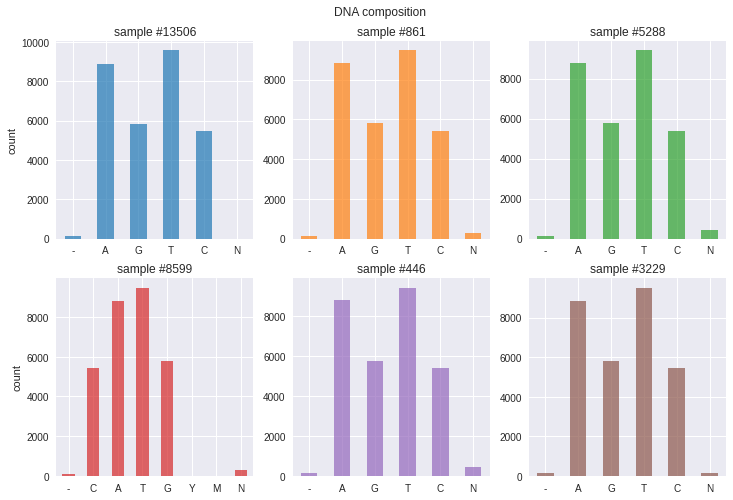

In [ ]:
plt.style.use('seaborn')
colors = list(mpl.colors.TABLEAU_COLORS)
rows, cols = 2, 3

fig, axes = plt.subplots(rows, cols, sharex=False, figsize=(cols * 4, rows * 4))
for i, ax in enumerate(axes.ravel()):
  sample = np.random.randint(0, len(records))
  data = pd.Series(Counter(records[sample]))
  data.plot(ax=ax, kind='bar', alpha=0.7, color=colors[i], legend=False)
  ax.set_title(f'sample #{sample}')
  ax.tick_params(labelrotation=0)
  if i % cols == 0:
    ax.set_ylabel('count')
fig.suptitle('DNA composition', y=0.94)
plt.show()

In [ ]:
# c = Counter()
# for record in records:
#   c.update(Counter(record))
# c

# output:
# '-': 1577748,
# 'A': 125543795,
# 'B': 5,
# 'C': 77254785,
# 'D': 4,
# 'G': 82536924,
# 'H': 7,
# 'K': 3085,
# 'M': 388,
# 'N': 4992745,
# 'R': 1562,
# 'S': 411,
# 'T': 135009368,
# 'V': 8,
# 'W': 526,
# 'Y': 3770

# Experiment with a subset of the data

## Sample and encode

In [ ]:
np.random.seed(3264)
idx = np.random.choice(len(records), size=3, replace=False)
records_sub = records[idx]
print('taking', records_sub.shape[0], 'records')

taking 3 records


In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(lower=False, char_level=True)
tokenizer.fit_on_texts(records_sub)
sequences_sub = tokenizer.texts_to_sequences(records_sub)
sequences_sub = np.asarray(sequences_sub) - 1
n_vocabs = len(tokenizer.index_word)

print('sequences_sub shape:', sequences_sub.shape)
print('vocabs:', [key for key in tokenizer.word_index])
print('n_vocabs:', n_vocabs)

sequences_sub shape: (3, 29903)
vocabs: ['T', 'A', 'G', 'C', 'N', '-', 'K']
n_vocabs: 7


In [ ]:
sequences_sub_encode = keras.utils.to_categorical(sequences_sub)

print('sequences_sub_encode shape:', sequences_sub_encode.shape)

sequences_sub_encode shape: (3, 29903, 7)


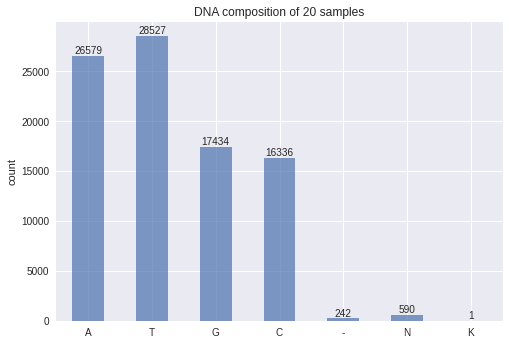

In [ ]:
data = pd.Series(tokenizer.word_counts)
ax = data.plot(kind='bar', alpha=0.7, legend=False)
ax.set_ylabel('count')
ax.set_xticklabels(data.index)
ax.set_title('DNA composition of 20 samples')
ax.tick_params(labelrotation=0)
for child in ax.get_children():
    if isinstance(child, mpl.patches.Rectangle) and child.get_x():
        ax.text(child.get_x() + 0.25, child.get_y() + child.get_height(),
                child.get_height(), va='bottom', ha='center')
plt.show()

## Create the dataset

In [ ]:
window_size = 1000
batch_size = 64

def data_generator():
    for i in range(len(records_sub)):
        for t in range(seq_len - window_size):
            yield (sequences_sub_encode[i][t:t + window_size],
                   sequences_sub_encode[i][t + window_size])
            
dataset = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.float32),
                                         ((window_size,n_vocabs), (n_vocabs)))
dataset = dataset.shuffle(1000).batch(batch_size).prefetch(2)

## Build the model

In [ ]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Input(shape=(window_size, n_vocabs)),
    # keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(n_vocabs, activation='softmax')
])
optimizer = keras.optimizers.RMSprop()
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               69632     
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 70,535
Trainable params: 70,535
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def save_every_15(epoch, logs):
    epoch += 1
    if not epoch % 15:
        model.save(f'coivd_sub_{epoch}.h5')

callbacks = [
    keras.callbacks.CSVLogger('log_sub.csv', append=True),
    keras.callbacks.LambdaCallback(on_epoch_end=save_every_15)
]

model.fit(dataset, batch_size=batch_size, epochs=90, callbacks=callbacks)

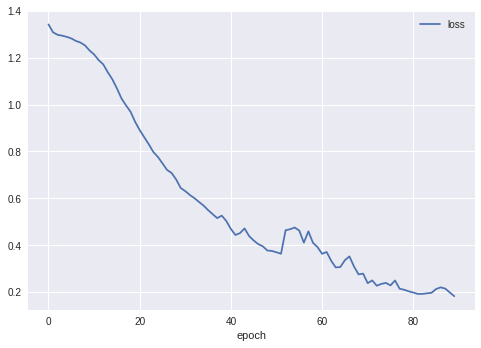

In [ ]:
# 210s / 3600 * 90 = 5.25 hours
# ~151ms/step
ax = pd.read_csv('log_sub.csv', index_col=0).plot()

## Generate sequences

In [ ]:
model = keras.models.load_model('covid_sub_90.h5')

def sample(preds, temperature=1.0):
    preds = preds.astype(np.float64)
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), size=1, p=preds).item() + 1

In [ ]:
%%timeit
preds = model.predict(sequences_sub_encode[0:1, :1000])[0]
next_idx = sample(preds)
next_idx

10 loops, best of 3: 66.3 ms per loop


In [ ]:
seed = sequences_sub[0:1, :1000]
generated = []
target_len = seq_len - window_size
x = keras.utils.to_categorical(seed, n_vocabs)
print('target_len:', target_len)

target_len: 28903


In [ ]:
%%time
# 66ms / 1000 / 60 * 29900 = 33 minutes

while len(generated) < target_len:
    preds = model.predict(x)[0] # 66ms
    next_idx = sample(preds)
    generated.append(next_idx)

    x_next = np.roll(x, shift=-1, axis=1)
    x_next[:, -1, :] = 0
    x_next[:, -1, next_idx - 1] = 1
    x = x_next

CPU times: user 28min 30s, sys: 5min 21s, total: 33min 52s
Wall time: 33min 30s


In [ ]:
generated_text = ''.join([tokenizer.index_word[idx] for idx in generated])
seed_text = ''.join([tokenizer.index_word[idx + 1] for idx in seed[0]])
result = seed_text + generated_text
print(len(result))

29903


In [ ]:
print(result[1000:])

GAAAAAGCCACGTCTAACAAAGGCTGTGATTTAGATGAGTTGGACCGTCAAGCACCTACGAGACCTAATGTTTCATTGCAGTGTGTCTATGCTGATTCTAAAGTAGATGCTTGCCTTACATGTTCACATGTAACACGCTATAAGAATGGTTCACTTATTGGTGGTTTCAATGTACCTGTAAAGTGCACACTTACATGGCTCAATCATTGCTACTCAGCTTTACCATCATCTTTAATCTTGTGTGCCAATCTTGACAATGGCACTTATGGTGCACGTCAGTCAGTGTCAACTGGAAACCAGTTCTGCCGTCAAGCTGCTCAGCCTCATGCACCAGGACCTAATTTCACAATGCCATTTGCTTCAAACGGTTTAGGGGCTGTTGTAGATTCAACATTAGATTCAGATGCTGCACCAGCAGTTCCAATTGACACAATCCAAGGTGTCGTCTCTAAGGATATCACACTACAGATGGCCACTCTTTGGAATGCAGAAGACAGTGAAGTAGTTGTTATATACTGGAATTCAGAATCTGACTATAGCTTCTCAAGGGAACTGGTAACACCAGTAGCTTACTCTAACTCATTGTTCTGACACTATTAAATGGCCATATTACGTACTAGATCCATTAATTGCTTTATTGTCTTAACTTAACTGTAGTACAAACGTTGGTAAGAGTGTACTCCTCGGAACTGGTGAAATGCTATTCACACAAGGTAAATTCTATGACATTGACAAGTCAAATCTTAATATGTTGTTGTTTTTTTGTGCATAACAGTTTCATGTCACTATAGTGTCAGACCAGTCTTGCTTCAGAGTTGTACGCACTAGTGGTTCAGTTCCTTCCCACTTCATTGGTTGCAGTAGTCGTGTTAGTAAATCTAAGTTAATGCTGGTTGAAAAGACGTGTAACCAAGGTAGATTGCTCTATAATTGGTGGTAAGGCTACACTTAAACTTCTTAACATTGCTAGGCTTTATCAACAAGGAAGACCTATTAATGG

In [ ]:
print(records_sub[0][1000:])

GAAAAGAGCTATGAATTGCAGACACCTTTTGAAATTAAATTGGCAAAGAAATTTGACACCTTCAATGGGGAATGTCCAAATTTTGTATTTCCCTTAAATTCCATAATCAAGACTATTCAACCAAGGGTTGAAAAGAAAAAGCTTGATGGCTTTATGGGTAGAATTCGATCTGTCTATCCAGTTGCGTCACCAAATGAATGCAACCAAATGTGCCTTTCAACTCTCATGAAGTGTGATCATTGTGGTGAAACTTCATGGCAGACGGGCGATTTTGTTAAAGCCACTTGCGAATTTTGTGGCACTGAGAATTTGACTAAAGAAGGTGCCACTACTTGTGGTTACTTACCCCAAAATGCTGTTGTTAAAATTTATTGTCCAGCATGTCACAATTCAGAAGTAGGACCTGAGCATAGTCTTGCCGAATACCATAATGAATCTGGCTTGAAAACCATTCTTCGTAAGGGTGGTCGCACTATTGCCTTTGGAGGCTGTGTGTTCTCTTATGTTGGTTGCCATAACAAGTGTGCCTATTGGGTTCCACGTGCTAGCGCTAACATAGGTTGTAACCATACAGGTGTTGTTGGAGAAGGTTCCGAAGGTCTTAATGACAACCTTCTTGAAATACTCCAAAAAGAGAAAGTCAACATCAATATTGTTGGTGACTTTAAACTTAATGAAGAGATCGCCATTATTTTGGCATCTTTTTCTGCTTCCACAAGTGCTTTTGTGGAAACTGTGAAAGGTTTGGATTATAAAGCATTCAAACAAATTGTTGAATCCTGTGGTAATTTTAAAGTTACAAAAGGAAAAGCTAAAAAAGGTGCCTGGAATATTGGTGAACAGAAATCAATACTGAGTCCTCTTTATGCATTTGCATCAGAGGCTGCTCGTGTTGTACGATCAATTTTCTCCCGCACTCTTGAAACTGCTCAAAATTCTGTGCGTGTTTTACAGAAGGCCGCTATAACAATACTAGATGGAATTTCACAGTATTCACTGA

# Train on full dataset

Training was very slow due to the huge amount of samples, so I did not train the model.

## Encode

In [ ]:
%%time
tokenizer = keras.preprocessing.text.Tokenizer(lower=False, char_level=True)
tokenizer.fit_on_texts(records)
sequences = tokenizer.texts_to_sequences(records)
sequences = np.asarray(sequences) - 1
n_vocabs = len(tokenizer.index_word)

print('sequences_sub shape:', sequences.shape)
print('vocabs:', [key for key in tokenizer.word_index])
print('n_vocabs:', n_vocabs)

sequences_sub shape: (14277, 29903)
vocabs: ['T', 'A', 'G', 'C', 'N', '-', 'Y', 'K', 'R', 'W', 'S', 'M', 'V', 'H', 'B', 'D']
n_vocabs: 16
CPU times: user 3min 18s, sys: 10.6 s, total: 3min 29s
Wall time: 3min 29s


## Create the dataset

In [ ]:
window_size = 10000
batch_size = 128

def data_generator():
    for i in range(len(records)):
        for t in range(seq_len - window_size):
            yield (keras.utils.to_categorical(sequences[i][t:t + window_size], n_vocabs),
                   keras.utils.to_categorical(sequences[i][t + window_size], n_vocabs))
            
dataset = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.float32),
                                         ((window_size,n_vocabs), (n_vocabs)))
dataset = dataset.shuffle(1000).batch(batch_size).prefetch(2)

## Build the model

In [ ]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Input(shape=(window_size, n_vocabs)),
    # keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(n_vocabs, activation='softmax')
])
optimizer = keras.optimizers.RMSprop()
model.compile(optimizer=optimizer, loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
Total params: 76,304
Trainable params: 76,304
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 2s/step
# 2562/Unknown - 3896s 2s/step - loss: 1.3352
# model.fit(dataset, batch_size=batch_size, epochs=1)